In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import numpy as np
from scipy.io.wavfile import write
import os
from pathlib import Path

In [57]:
def trim_audio(x):
    middle = np.where(x == max(x[int(len(x)*0.1):int(len(x)*0.95)]))[0][0]
    minI, maxI = middle, middle
    while max(abs(x[minI:minI+500])) > 0.1:
        minI -= 50
    while max(abs(x[maxI-500:maxI])) > 0.1:
        maxI += 50
    return x[minI-500:maxI+1000] if minI > 500 else x[minI:maxI+1000]

In [77]:
def process_audio(fn):
    path = Path(fn)
    if fn == None:
        print("Not valid File")
    
    # checks to see if file already exists
    if Path("/".join(path.parts[:-1])+"/.Processed/p"+path.name).is_file():
        file = "/".join(path.parts[:-1])+"/.Processed/p"+path.name
        time = librosa.get_duration(filename=file)
        return librosa.load(file, sr = int(4410/time))
        
    x, sr = librosa.load(fn)
    
    #trim audio
    x = trim_audio(x)
    
    #convert to audio file
    strdir = "/".join(path.parts[:-1])+"/.Processed/"
    try:
        os.mkdir(strdir)
    except:
        pass
        
    newFilename = strdir + 'p' + path.name
    #scaled = np.int16(x/np.max(np.abs(x)) * 32767)
    write(newFilename, sr, x)
    time = librosa.get_duration(filename=newFilename)
    x, sr = librosa.load(newFilename, sr = int(4410/time))
    return x, sr

In [50]:
def get_np_difs(np1, np2):
    dif_df = np.square(np1 - np2)
    row_dif = np.sum(np.sqrt(np.sum(np.square(np1.copy()), axis = 1))) - np.sum(np.sqrt(np.sum(np.square(np2.copy()), axis = 1)))
    col_dif = np.sum(np.sqrt(np.sum(dif_df, axis = 0)))
    return row_dif, col_dif

In [51]:
def get_zero_crossing_dif(x1, x2):
    zero_crossings1 = librosa.zero_crossings(x1, pad=False)
    zero_crossings2 = librosa.zero_crossings(x2, pad=False)
    return sum(zero_crossings1) - sum(zero_crossings2)

In [52]:
def ridge_regression(row_dif, col_dif, num_zero_crossings):
    return row_dif**2 + col_dif**2 + num_zero_crossings**2

In [53]:
import csv

x = 0
with open('UASpeech/speaker_wordlist.csv', mode='r') as infile:
    reader = csv.reader(infile)
    word_dict = {rows[1]:rows[0] for rows in reader}
del word_dict['FILE NAME']

In [79]:
def get_word_from_filename(fn):
    path = Path(fn)
    fn = path.name.split('_')
    return word_dict[fn[1]+"_"+fn[2]] if "UW" in fn[2] else word_dict[fn[2]]

In [55]:
def compare(person, word, first_word_filename, min_difs, min_file, x1, sr1, mfccs1):
    for i in range(1,4):
        if i == 2:
            continue
        x2, sr, mfccs2 = np.array([]), 0, np.array([])
        
        filename = f"UASpeech/audio/{person}/{person}_B{i}_{word}_M5.wav"
        if not Path(filename).is_file():
            filename = f"UASpeech/audio/{person}/{person}_B{i}_{word}_M6.wav"
        if first_word_filename != filename:
            x2, sr = process_audio(filename)
            mfccs2 = librosa.feature.mfcc(x2, sr=sr)
        else:
            continue
        
        if abs(len(x1)/sr1 - len(x2)/sr) > 0.1:
            continue
        difs = get_np_difs(mfccs1, mfccs2)
        ridge_dif = ridge_regression(difs[0], difs[1], get_zero_crossing_dif(x1, x2))
        if min_difs == None or min_difs > ridge_dif:
            min_difs = ridge_dif
            min_file = filename
        
    return min_difs, min_file

In [29]:
def get_accuracy_of_person(person):
    total_accuracy = 0
    for w in range(1, 101):
        first_word_filename = f"UASpeech/audio/{person}/{person}_B2_CW{w}_M3.wav"
        if not Path(first_word_filename).is_file():
            first_word_filename = f"UASpeech/audio/"+person+"/"+person+"_B2_CW"+str(w)+"_M4.wav"
        word = get_word_from_filename(first_word_filename)
        min_difs = None
        min_file = ""
        x1, sr1 = process_audio(first_word_filename)
        mfccs1 = librosa.feature.mfcc(x1, sr=sr)
        for i in range(1, 101):
            min_difs, min_file = compare(person, "CW"+str(i), first_word_filename, min_difs, min_file, x1, sr1, mfccs1)

        total_accuracy += get_word_from_filename(min_file) == word
    print(f"total_accuracy of {person} = {total_accuracy}%")
    return round(total_accuracy, 2)
person_accuracy = {}
#print(get_accuracy_of_person("M16"))
for person in os.listdir("UASpeech/audio/"):
    try:
        person_accuracy[person] = get_accuracy_of_person(person)
        print(person_accuracy[person])
    except:
        print(f"Error with {person}")
print(person_accuracy)
'''31% accuracy with corret implementation of row col
35% with incorrect row col'''

total_accuracy of M08 = 24%
24
total_accuracy of F02 = 38%
38
Error with M01
total_accuracy of M05 = 38%
38
total_accuracy of M14 = 27%
27
total_accuracy of F04 = 10%
10
total_accuracy of F05 = 16%
16


/home/mihir/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Error with F03
Error with .DS_Store
total_accuracy of M09 = 25%
25
total_accuracy of M10 = 14%
14
total_accuracy of M11 = 21%
21
total_accuracy of M04 = 9%
9
total_accuracy of M07 = 24%
24
Error with control


/home/mihir/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


total_accuracy of M16 = 20%
20
Error with M12
{'M08': 24, 'F02': 38, 'M05': 38, 'M14': 27, 'F04': 10, 'F05': 16, 'M09': 25, 'M10': 14, 'M11': 21, 'M04': 9, 'M07': 24, 'M16': 20}


'31% accuracy with corret implementation of row col\n35% with incorrect row col'

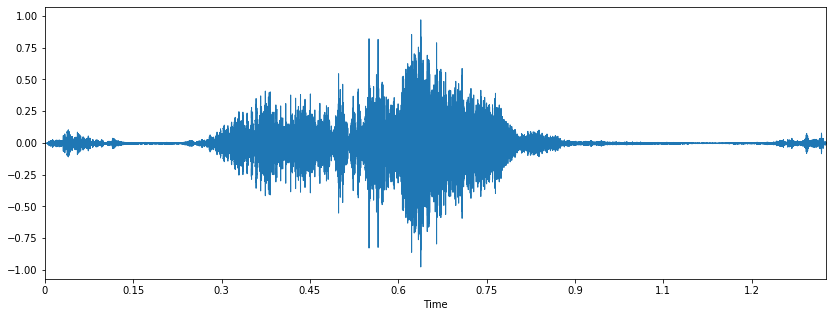

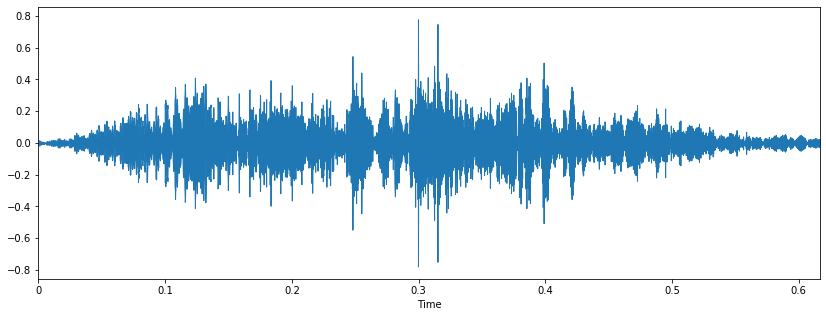

In [78]:
#Graph of wavform (Amplitude vs Time) before processing the audio file
x, sr = librosa.load("UASpeech/audio/M16/M16_B3_CW100_M4.wav")
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

#Graph of wavform (Amplitude vs Time) after processing the audio file
x, sr = process_audio("UASpeech/audio/M16/M16_B3_CW100_M4.wav")
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

len = 0.3
0.3741727473273375


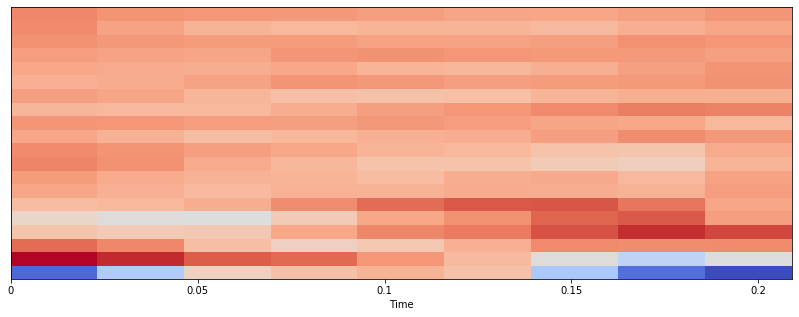

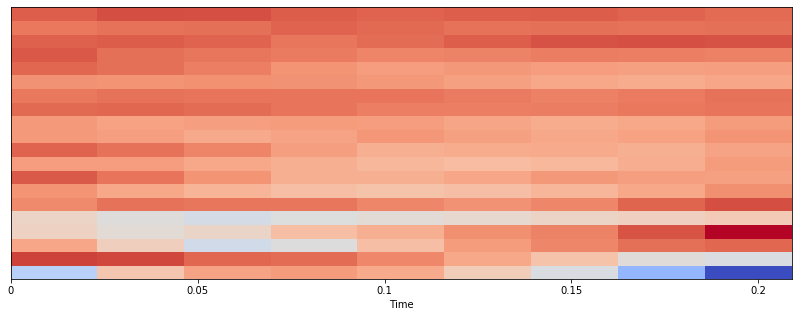

In [18]:
x, sr = process_audio("UASpeech/audio/M16/M16_B3_CW100_M4.wav")
#x, sr = librosa.load("UASpeech/audio/M16/M16_B2_UW65_M4.wav")
print("len =", round(len(x)/sr, 1))
mfcc = librosa.feature.mfcc(x, sr=sr)
#x1 = trim_audio(x)
#print("trimmed len =", len(x1))
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, x_axis='time')
x, sr = process_audio("UASpeech/audio/M16/M16_B2_CW100_M3.wav")
print(len(x)/sr)
#x, sr = process_audio("UASpeech/audio/M16/M16_B2_CW2_M7.wav")
mfcc = librosa.feature.mfcc(x, sr=sr)
plt.figure(figsize=(14, 5))
librosa.display.specshow(mfcc, x_axis='time')

In [26]:
p2 = person_accuracy.copy()
p1, p2

NameError: name 'person_accuracy' is not defined

In [48]:
%%timeit
#for w in range(1, 101):
first_word_filename = f"UASpeech/audio/M16/M16_B2_CW9_M3.wav"
if not Path(first_word_filename).is_file():
    first_word_filename = f"UASpeech/audio/M16/M16_B2_CW9_M4.wav"
word = get_word_from_filename(first_word_filename)
min_difs = None
min_file = ""
x1, sr1 = None, None

x1, sr1 = process_audio(first_word_filename)
mfccs1 = librosa.feature.mfcc(x1, sr=sr)
for i in range(1, 101):
    min_difs, min_file = compare("M16", "CW"+str(i), first_word_filename, min_difs, min_file, x1, sr1, mfccs1)
#for i in range(1,20):
#min_difs, min_file, second_min_difs, second_min_file = compare("M16", "C"+str(i), first_word_filename, min_difs, min_file, second_min_difs, second_min_file, x1, mfccs1)
#print(min_file)
print("expected: "+get_word_from_filename(first_word_filename)+"\t recieved: ", end="")
print(get_word_from_filename(min_file), min_file)
    #print("expected: "+word+"\t recieved: ", end="")
    #print(guesses[0]+"\t"+guesses[1]+"\t"+guesses[2]+"\t\taccuracy: "+str(round(guesses.count(word)*100/3, 2)) + "%")
    #print(w, end="\t")
    #total_accuracy += get_word_from_filename(min_file) == word
#print(f"total_accuracy of M16 = {total_accuracy}%")

expected: that	 recieved: that UASpeech/audio/M16/M16_B1_CW9_M5.wav
expected: that	 recieved: that UASpeech/audio/M16/M16_B1_CW9_M5.wav
expected: that	 recieved: that UASpeech/audio/M16/M16_B1_CW9_M5.wav
expected: that	 recieved: that UASpeech/audio/M16/M16_B1_CW9_M5.wav
expected: that	 recieved: that UASpeech/audio/M16/M16_B1_CW9_M5.wav
expected: that	 recieved: that UASpeech/audio/M16/M16_B1_CW9_M5.wav
expected: that	 recieved: that UASpeech/audio/M16/M16_B1_CW9_M5.wav
expected: that	 recieved: that UASpeech/audio/M16/M16_B1_CW9_M5.wav
4.26 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit
for i in range(1, 101):
    process_audio(f"UASpeech/audio/M16/M16_B1_CW5_M3.wav")

4.37 s ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
